# Load in Cleaned Dataset: `demo_killings_df`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from tqdm.notebook import tqdm

from collections import defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

In [2]:
with open('Data/demo_killings_df.pkl','rb') as read_file:
    demo_killings_df = pickle.load(read_file)

In [3]:
demo_killings_df

merge_key    id                name       date  year    month  \
0           Shelton_WA     3          Tim Elliot 2015-01-02  2015  January   
1             Aloha_OR     4    Lewis Lee Lembke 2015-01-02  2015  January   
2           Wichita_KS     5  John Paul Quintero 2015-01-03  2015  January   
3     San_Francisco_CA     8     Matthew Hoffman 2015-01-04  2015  January   
4             Evans_CO     9   Michael Rodriguez 2015-01-04  2015  January   
...                ...   ...                 ...        ...   ...      ...   
2345     Chowchilla_CA  2812  Alejandro Alvarado 2017-07-27  2017     July   
2346    Kansas_City_MO  2822    Rodney E. Jacobs 2017-07-28  2017     July   
2347    Albuquerque_NM  2813               TK TK 2017-07-28  2017     July   
2348          Melba_ID  2818  Dennis W. Robinson 2017-07-29  2017     July   
2349        Oshkosh_WI  2817       Isaiah Tucker 2017-07-31  2017     July   

     day_of_week      region   manner_of_death              armed  ...  \
0         Friday  West Coast              shot                gun  ...   
1         Friday  West Coast              shot                gun  ...   
2       Saturday     Central  shot and Tasered            unarmed  ...   
3         Sunday  West Coast              shot  non-lethal object  ...   
4         Sunday    Mountain              shot                gun  ...   
...          ...         ...               ...                ...  ...   
2345    Thursday  West Coast              shot       sharp object  ...   
2346      Friday     Midwest              shot                gun  ...   
2347      Friday    Mountain              shot            vehicle  ...   
2348    Saturday    Mountain              shot                gun  ...   
2349      Monday     Midwest              shot            vehicle  ...   

      body_camera city_type poverty_rate percent_completed_hs share_white  \
0           False      City         28.6                 80.1        78.9   
1           False       Cdp         14.9                 88.1        70.9   
2           False      City         17.3                 87.5        71.9   
3           False      City         13.2                 87.0        48.5   
4           False      City         16.6                 76.3        76.5   
...           ...       ...          ...                  ...         ...   
2345        False      City         32.1                 68.3        61.6   
2346        False      City         19.0                 88.4        59.2   
2347        False      City         19.2                 89.0        69.7   
2348        False      City         16.4                 90.4        78.9   
2349         True      City         17.9                 89.3        90.5   

      share_black share_native_american share_asian  share_hispanic  \
0             0.8                   3.7         1.1            19.2   
1             2.6                   1.0         8.9            21.1   
2            11.5                   1.2         4.8            15.3   
3             6.1                   0.5        33.3            15.1   
4             0.9                   1.2         0.9            43.1   
...           ...                   ...         ...             ...   
2345         12.6                   2.0         2.1            37.8   
2346         29.9                   0.5         2.5            10.0   
2347          3.3                   4.6         2.6            46.7   
2348          0.2                   0.0         0.2            24.6   
2349          3.1                   0.8         3.2             2.7   

     median_income  
0          37072.0  
1          65765.0  
2          45947.0  
3          81294.0  
4          47791.0  
...            ...  
2345       34559.0  
2346       45821.0  
2347       47030.0  
2348       41154.0  
2349       42650.0  

[2350 rows x 28 columns]

# Prepare Dataset for Modeling

## Consolidate to specific races (W, B, H)

In [4]:
class_killings_df = demo_killings_df.loc[demo_killings_df['race'].isin(['W', 'B', 'H'])].reset_index(drop=True)


In [5]:
class_killings_df.race.value_counts()

W    1066
B     587
H     421
Name: race, dtype: int64

## Convert Features to Desired Data Types

- numerical
    - year
    - age
    - poverty_rate
    - percent_completed_hs
    - share_white
    - share_black
    - share_native_american
    - share_asian
    - share_hispanic
    - median_income
- boolean
    - gender
    - top 30 city
    - signs_of_mental_illness
    - body_camera
- categorical
    - month
    - day_of_week
    - manner_of_death
    - armed
    - state
    - threat_level
    - flee

### Boolean

In [6]:
# Race (target variable)

class_killings_df.race = [0 if race == 'W' else 1 for race in class_killings_df.race.values]

In [7]:
# Gender

class_killings_df.gender = [1 if gen == 'M' else 0 for gen in class_killings_df.gender.values]

In [8]:
# Manner of Death

class_killings_df.manner_of_death = [1 if gun == 'shot' else 0 for gun in class_killings_df.manner_of_death.values]


In [9]:
# Top 30 City

top_30_city = [1 if city in class_killings_df.city.value_counts().index[:30] else 0 for city in class_killings_df.city.values]

class_killings_df.insert(7, 'top_30_city', top_30_city)

In [10]:
# Armed

class_killings_df.armed = [0 if arm == 'unarmed' else 1 for arm in class_killings_df.armed.values]

In [11]:
# Flee

class_killings_df.flee = [0 if flee == 'Foot' else 1 for flee in class_killings_df.flee.values]

In [12]:
# Threat Level

class_killings_df.threat_level = [0 if threat == 'undetermined' else 1 for threat in class_killings_df.threat_level.values]

In [13]:
# Signs of Mental Illness, Body Camera

for column in ['signs_of_mental_illness', 'body_camera']:
    class_killings_df[column] = [1 if i == True else 0 for i in class_killings_df[column].values]

### Categorical

In [14]:
class_killings_df.columns

Index(['merge_key', 'id', 'name', 'date', 'year', 'month', 'day_of_week',
       'top_30_city', 'region', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'city_type', 'poverty_rate',
       'percent_completed_hs', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic',
       'median_income'],
      dtype='object')

In [15]:
model_killings_df = class_killings_df[['year', 'month', 'day_of_week', 'top_30_city', 'city_type', 'region',
                                       'age', 'gender', 'manner_of_death', 'armed', 'signs_of_mental_illness', 
                                       'threat_level', 'flee', 'body_camera', 'poverty_rate', 'percent_completed_hs', 
                                       'share_white', 'share_black', 'share_native_american', 'share_asian', 
                                       'share_hispanic', 'median_income']]

In [16]:
# one hot encoding
model_killings_df = pd.get_dummies(model_killings_df, drop_first=True)

## Train-Test Split

In [17]:
X = model_killings_df.to_numpy()
y = class_killings_df.race.to_numpy()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Standardization

In [19]:
# std = StandardScaler()
# std.fit(X_train.values)

# X_tr_scaled = std.transform(X_train.values)
# X_te_scaled = std.transform(X_test.values)

# X_tr = pd.DataFrame(X_tr_scaled, index = X_train.index, columns = X_train.columns)
# X_te = pd.DataFrame(X_te_scaled, index = X_test.index, columns = X_test.columns)

# Modeling

## Baseline Models

In [20]:
class_results_dict = defaultdict(list)

In [21]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [22]:
model_dict = {'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),    \
              'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors = 10),    \
#               'Naive Bayes': MultinomialNB(),    \
#               'LinearSVM': SGDClassifier(random_state=42),    \
#               'Non-linear SVM': SVC(gamma="scale"),    \
#               'Neural Network': MLPClassifier(),    \
              'Decision Tree': DecisionTreeClassifier(max_depth=6, random_state=42),    \
              'Random Forest': RandomForestClassifier(n_estimators = 1000, max_depth=6, random_state=42),    \
              'AdaBoost': AdaBoostClassifier(n_estimators = 1000, random_state=42),    \
              'Gradient Boost': GradientBoostingClassifier(n_estimators = 1000, max_depth=6, random_state=42),
              'XGBoost': XGBClassifier(n_estimators = 1000, max_depth=6, random_state=42)
             }

In [23]:
for mod_name, model in tqdm(model_dict.items()):
    
    print(mod_name)
    cv = 1
    
    for train_ind, val_ind in kf.split(X_train, y_train):
        X_train_ind, y_train_ind = X_train[train_ind], y_train[train_ind]
        X_smote_train, y_smote_train = SMOTE(random_state=42).fit_sample(X_train_ind, y_train_ind)
        
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        
        model.fit(X_smote_train, y_smote_train);
        y_pred = model.predict(X_val)

        accuracy = round(100*accuracy_score(y_val, y_pred),3)
        precision = round(100*precision_score(y_val, y_pred),3)
        recall = round(100*recall_score(y_val, y_pred),3)
        f1 = round(2 * (precision * recall) / (precision + recall),3)

        class_results_dict['Model_Name'].append(mod_name + ' ' + str(cv))
        class_results_dict['Accuracy'].append(accuracy)
        class_results_dict[('Precision')].append(precision)
        class_results_dict[('Recall')].append(recall)
        class_results_dict[('F1-score')].append(f1)
        
        cv += 1

class_results_full = pd.DataFrame(class_results_dict)
class_results_full.Model_Name = class_results_full.Model_Name.str.strip('12345')
class_results_df = class_results_full.groupby(['Model_Name']).mean()

Logistic Regression
K-Nearest Neighbors
Decision Tree
Random Forest
AdaBoost
Gradient Boost
XGBoost



In [24]:
class_results_df.sort_values(by='F1-score', ascending=False).reset_index()

Model_Name  Accuracy  Precision   Recall  F1-score
0        Random Forest    76.4916    73.7480  80.1472   76.7980
1  Logistic Regression    76.2510    74.9362  76.9190   75.8804
2        Decision Tree    71.8514    70.0490  73.8118   71.7666
3              XGBoost    72.0308    71.0814  71.5848   71.3210
4       Gradient Boost    71.7294    70.8764  70.9650   70.8778
5             AdaBoost    71.2478    70.0060  71.5866   70.7298
6  K-Nearest Neighbors    62.0258    61.6854  57.5778   59.4906

## Further Evaluation of Best Baseline Models

- **Logistic Regression**
- **Random Forest**
- **Gradient Boost**

In [25]:
# Logistic Regression

logit = LogisticRegression(max_iter=1000)

In [26]:
logit.fit(X_smote_train, y_smote_train)
y_pred_logit = logit.predict(X_val)

In [27]:
# Random Forest

rf = RandomForestClassifier(n_estimators = 1000, max_depth=6, random_state=42)

In [28]:
rf.fit(X_smote_train, y_smote_train)
y_pred_rf = rf.predict(X_val)

In [29]:
# Gradient Boost

grad = GradientBoostingClassifier(n_estimators = 1000, max_depth=6, random_state=42)

In [30]:
grad.fit(X_smote_train, y_smote_train)
y_pred_grad = grad.predict(X_val)

---

In [31]:
# Confusion Matrix Function

def conf_matrix(actual, predicted, model_name):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_white', 'predicted_poc'], 
                yticklabels=['actual_white', 'actual_poc'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    bottom, top = ax.get_ylim()
    ax.set_title(model_name + ' Confusion Matrix')
    ax.set_ylim(bottom, top)
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    return

In [32]:
# ROC Curve Function

def roc_curve_generator(X_test, y_test, model_name, model_variable):

    roc_curve_dict = defaultdict(list)
    
    fpr, tpr, thresholds = roc_curve(y_test, model_variable.predict_proba(X_test)[:,1])
    roc_curve_dict[model_name] = pd.DataFrame(list(zip(fpr, tpr, thresholds)),    \
                                              columns=['False Positive Rate','True Positive Rate', 'Threshhold'])
    
    # Plot roc_curve
    
#     fig1 = plt.figure(figsize=[9,9], dpi=100)

#     plt.plot(roc_curve_dict[model_name]['False Positive Rate'].values,    \
#              roc_curve_dict[model_name]['True Positive Rate'].values,    \
#              lw=2, label=model_name)

#     plt.plot([0,1],[0,1],c='violet',ls='--')
#     plt.xlim([-0.05,1.05])
#     plt.ylim([-0.05,1.05])

#     plt.xlabel('False positive rate', fontsize=15)
#     plt.ylabel('True positive rate', fontsize=15)
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.title('ROC Curve', fontsize=15);
#     plt.legend(fontsize=10)
    
    return roc_curve_dict

In [33]:
# Precision-Recall Curve Function

def prec_rec_curve_generator(X_test, y_test, model_name, model_variable):

    prec_rec_curve_dict = defaultdict(list)
    
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model_variable.decision_function(X_test))
    prec_rec_curve_dict[model_name] = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),    \
                                                   columns=['precision','recall','threshold'])

    # Plot precision_recall_curve
    
    fig2 = plt.figure(figsize=[9,9], dpi=100)

    plt.plot(prec_rec_curve_dict[model_name]['recall'].values,    \
             prec_rec_curve_dict[model_name]['precision'].values,    \
             lw=2, label=model_name)

    plt.plot([1,0],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Precision-Recall Curve', fontsize=15);
    plt.legend(fontsize=10)
    
    return prec_rec_curve_dict

#### Confusion Matrix

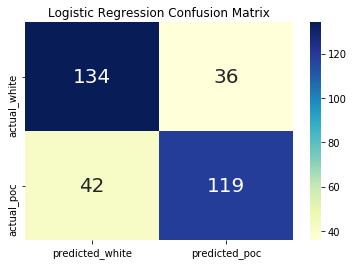

In [34]:
conf_matrix(y_val, y_pred_logit, 'Logistic Regression')

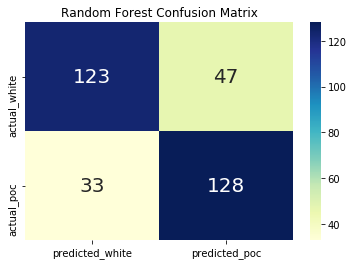

In [35]:
conf_matrix(y_val, y_pred_rf, 'Random Forest')

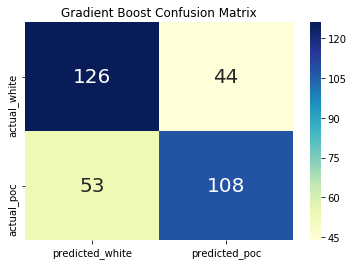

In [36]:
conf_matrix(y_val, y_pred_grad, 'Gradient Boost')

#### ROC Curve

In [37]:
logit_roc = roc_curve_generator(X_val, y_val, 'Logistic Regression', logit)
rf_roc = roc_curve_generator(X_val, y_val, 'Random Forest', rf)
grad_roc = roc_curve_generator(X_val, y_val, 'Gradient Boost', grad)

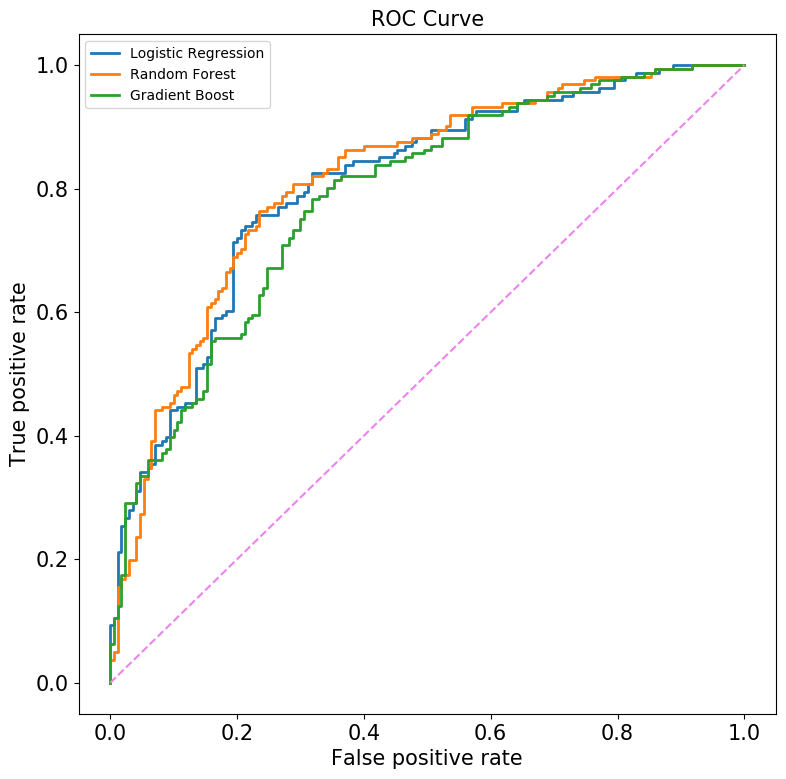

In [38]:
fig1 = plt.figure(figsize=[9,9], dpi=100)

plt.plot(logit_roc['Logistic Regression']['False Positive Rate'].values,    \
         logit_roc['Logistic Regression']['True Positive Rate'].values,    \
         lw=2, label='Logistic Regression')
plt.plot(rf_roc['Random Forest']['False Positive Rate'].values,    \
         rf_roc['Random Forest']['True Positive Rate'].values,    \
         lw=2, label='Random Forest')
plt.plot(grad_roc['Gradient Boost']['False Positive Rate'].values,    \
         grad_roc['Gradient Boost']['True Positive Rate'].values,    \
         lw=2, label='Gradient Boost')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve', fontsize=15);
plt.legend(fontsize=10)

#### Precision-Recall Curve

In [39]:
# logit_prec_rec = prec_rec_curve_generator(X_test, y_test, 'Logistic Regression', logit)

## GridSearch

In [40]:
def gridsearch(X_train, y_train, X_test, y_test, model, model_name, params, cv, score, error_score):
    
    gs = GridSearchCV(model, params, cv=cv, scoring=score, error_score=error_score)
    gs.fit(X_train, y_train)
    y_true, y_pred = y_test, gs.predict(X_test)
    
    print(model_name)
    print('-------------------------------------')
    print('Best Parameters are:', gs.best_params_)
    print('accuracy =', accuracy_score(y_true, y_pred))
    print('precision = ', precision_score(y_true, y_pred))
    print('recall = ', recall_score(y_true, y_pred))
    print('f1 score = ', f1_score(y_true, y_pred))
    

In [41]:
# Logistic Regression
logit_params = [
                {'max_iter': [1000000]},
                {'penalty': ['none', 'l1','l2']},
                {'solver': ['liblinear']},
                {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]},
                {'random_state': [42]}
               ]

rf_params = [
             {'n_estimators': [10,100,1000]},
             {'max_depth': [2,6,10]},
             {'min_samples_leaf': [1,5,10]},
             {'max_leaf_nodes': [5,10]},
             {'random_state': [42]}
            ]



In [42]:
# gridsearch(X_train, y_train, X_test, y_test, RandomForestClassifier(),
#            'Random Forest', rf_params, 5, 'f1', 0.0)